# Interacción entre usuarios en la red BitCoin-Alpha
### Desarrollado por: Camilo Rey (camilorey@gmail.com)

primero vamos a importar las librerías que necesitamos para esto: Pandas para abrir el dataset en CSV, networkX para montar el grafo. Usaremos matplotlib para graficarlo. 

In [1]:
import pandas as Pandas
import networkx as NetworkX
import numpy as NumPy
import seaborn as SeaBorn
from datetime import datetime,timezone
import matplotlib.pyplot as PyPlot

Para abrir el archivo usaremos Pandas. Este archivo no contiene encabezado, entonces debemos ponerle los nombres de las columnas. Según la especificación, este archivo tiene cuatro columnas:
[SOURCE, TARGET, RATING, TIME]

vamos a llamar a las columnas según la descripción

In [2]:
nom_columnas = ['SOURCE','TARGET','RATING','TIME']
info_red = Pandas.read_csv('soc-sign-bitcoinalpha.csv',names=nom_columnas)
#cambiamos el formato de timestamp por un formato de fecha
info_red['TIME'] = info_red['TIME'].apply(lambda x: datetime.fromtimestamp(x,timezone.utc))
#cambiamos el nombre de la columna por fecha
info_red = info_red.rename(columns={'TIME':'DATE'})
print('Transacciones registradas',len(info_red))

Transacciones registradas 24186


El RATING es la calificación que da el emisor al receptor por cada transacción efectuada. Para calificar los usuarios entre sí. Así, de las transacciones efectuadas podríamos saber cuales son los receptores calificados como fraudulentos. Expandamos este campo de fecha para tener el año y mes de las transacciones. 

In [3]:
#aislamos los datos del Rating de las transacciones 
info_red['YEAR'] = info_red['DATE'].dt.year
info_red['MONTH'] = info_red['DATE'].dt.month
info_red

,SOURCE,TARGET,RATING,DATE,YEAR,MONTH
0,7188,1,10,2014-08-08 04:00:00+00:00,2014,8
1,430,1,10,2013-08-15 04:00:00+00:00,2013,8
2,3134,1,10,2013-05-28 04:00:00+00:00,2013,5
3,3026,1,10,2012-10-12 04:00:00+00:00,2012,10
4,3010,1,10,2012-09-17 04:00:00+00:00,2012,9
...,...,...,...,...,...,...
24181,7604,7601,10,2013-03-26 04:00:00+00:00,2013,3
24182,7601,7604,10,2013-03-26 04:00:00+00:00,2013,3
24183,7604,7602,10,2013-03-26 04:00:00+00:00,2013,3
24184,7602,7604,10,2013-03-26 04:00:00+00:00,2013,3


A partir de la reconstitución del campo TIME como DATE podemos observar cómo han variado en el tiempo las puntuaciones (ratings) a lo largo de los años. 

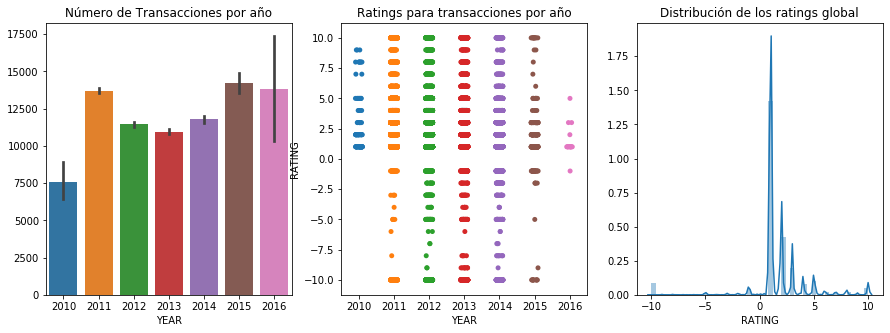

In [4]:
figura,subFiguras = PyPlot.subplots(1,3,figsize=(15,5))
subFiguras[0].set_title('Número de Transacciones por año')
subFiguras[1].set_title('Ratings para transacciones por año')
subFiguras[2].set_title('Distribución de los ratings global')
SeaBorn.barplot(data=info_red,x='YEAR',y=info_red.index,ax=subFiguras[0])
SeaBorn.stripplot(data=info_red,x='YEAR',y='RATING',ax=subFiguras[1])
SeaBorn.distplot(info_red['RATING'],ax=subFiguras[2])
PyPlot.show()

Si notamos, los ratings negativos comienzan a aparecer desde el año 2011. Veamos cómo han evolucionado en el tiempo, haciendo una gráfica en serie de tiempo

C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


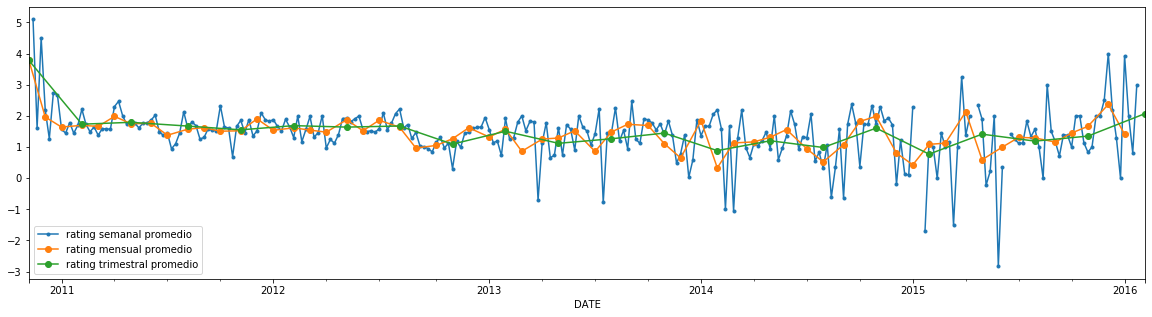

In [5]:
serie_ratings = info_red[['DATE','RATING']].set_index('DATE')
figura,subFigura = PyPlot.subplots(figsize=(20,5))
serie_ratings.resample('W').mean().plot(marker='.',linestyle='-',ax=subFigura)
serie_ratings.resample('M').mean().plot(marker='o',linestyle='-',ax=subFigura)
serie_ratings.resample('3M').mean().plot(marker='o',linestyle='-',ax=subFigura)
subFigura.legend(['rating semanal promedio','rating mensual promedio','rating trimestral promedio'])
PyPlot.show()

Ahora queremos saber cómo ha sido la evolución de los usuarios de la red de BitCoin y ver cuantos usuarios se han agregado a lo largo del tiempo. A la luz del dataset que tenemos, BitCoin Alpha comienza a operar en 2010 y continúa operando hasta el 2016. De este modo, podemos identificar todos los usuarios que pasaron por la red y encontrar tanto el año en el que entraron, como el año en el que salieron de la red y consecuentemente calcular el número de días de permanencia en *Bitcoin Alpha*.

In [178]:
serie_sources = info_red[['DATE','SOURCE']].rename({'SOURCE':'NAME'},axis=1)
serie_targets = info_red[['DATE','TARGET']].rename({'TARGET':'NAME'},axis=1)
serie_usuarios = Pandas.concat([serie_sources,serie_targets])
serie_usuarios = serie_usuarios.sort_values(by='DATE',ascending=True)
nom_usuarios = list(serie_usuarios['NAME'].unique())
usuarios = Pandas.DataFrame(columns=['NAME','START_YEAR','END_YEAR','DAYS_IN'])
for usuario in nom_usuarios:
    transac_usuario = serie_usuarios.loc[serie_usuarios['NAME']==usuario]
    primera = transac_usuario.iloc[0]['DATE'].date()
    ultima = transac_usuario.iloc[len(transac_usuario)-1]['DATE'].date()
    permanencia = ultima-primera
    fila_dict={'NAME':usuario,
              'START_YEAR':float(primera.year),
              'END_YEAR':float(ultima.year),
              'DAYS_IN':float(permanencia.days+1)}
    usuarios = info_usuarios.append(fila_dict,ignore_index=True)
usuarios

,NAME,START_YEAR,END_YEAR,DAYS_IN
0,113.0,2010.0,2014.0,1469.0
1,970.0,2010.0,2010.0,1.0
2,402.0,2010.0,2014.0,1259.0
3,2.0,2010.0,2015.0,1630.0
4,10.0,2010.0,2014.0,1502.0
...,...,...,...,...
3779,2437.0,2016.0,2016.0,1.0
3780,3450.0,2016.0,2016.0,1.0
3781,7370.0,2016.0,2016.0,1.0
3782,3451.0,2016.0,2016.0,1.0


Ahora podemos ver cómo ha sido la evolución de membresías a la red y cuantos usuarios se han ido agregando a lo largo de los años. 

C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


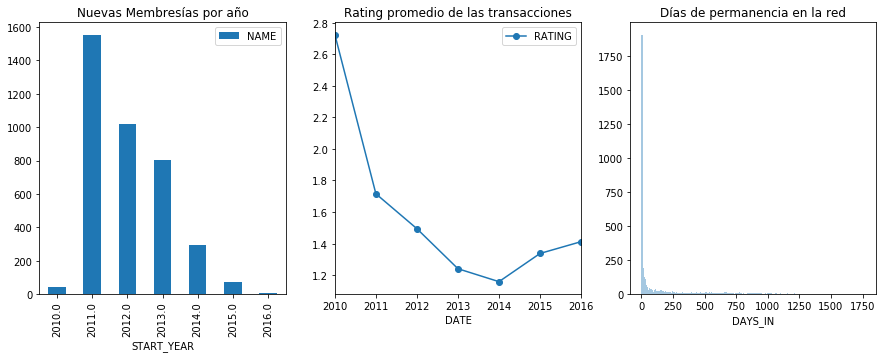

In [7]:
membresias_ano = Pandas.pivot_table(info_usuarios,index='START_YEAR',values='NAME',aggfunc='count').reset_index()
figura,subFiguras = PyPlot.subplots(1,3,figsize=(15,5))
subFiguras[0].set_title('Nuevas Membresías por año')
subFiguras[1].set_title('Rating promedio de las transacciones')
subFiguras[2].set_title('Días de permanencia en la red')
membresias_ano.plot.bar(x='START_YEAR',y='NAME',ax=subFiguras[0])
serie_ratings.resample('Y').mean().plot(marker='o',linestyle='-',ax=subFiguras[1])
SeaBorn.distplot(info_usuarios['DAYS_IN'],ax=subFiguras[2],kde=False,bins=200)
PyPlot.show()

Desde el año 2011 la red de BitCoin comienza a crecer en número  de usuarios con un pico en 2011, desde el cual comienzan las nuevas membresías a decaer. Al mismo tiempo, la calificación de las transacciones dentro de la red decae entre el año 2010 y el 2011. A mayor número de usuarios, la segridad y confiabilidad entre ellos (en sus evaluaciones) decae. Queremos saber ahora cómo están distribuidos los puntajes de cada usuario de la red para lo cual expandiremos la información de los usuarios contenida en el DataFrame *info_usuarios*, para crear un solo dataframe que contenga la información de los usuarios llamado *usuarios*.

In [8]:
def calcular_estadisticos(transacciones):
    promedio = transacciones['RATING'].mean()
    return promedio

def transacciones_usuario(nom_usuario):
    enviadas = info_red.loc[info_red['SOURCE']==nom_usuario]
    recibidas = info_red.loc[info_red['TARGET']==nom_usuario]
    return enviadas,recibidas

def clasificar_usuario(num_enviadas,num_recibidas):
    if num_enviadas == 0 and num_recibidas != 0:
        return 'RECEPTOR'
    elif num_enviadas !=0 and num_recibidas == 0:
        return 'EMISOR'
    else:
        return 'TRANSACCIONAL'
def calificaciones_usuario(tipo_usuario,enviadas,recibidas):
    if tipo_usuario == 'EMISOR':
        promedio = calcular_estadisticos(enviadas)
        return {'AVG_RATING_EMITTED':promedio}
    elif tipo_usuario=='RECEPTOR':
        promedio = calcular_estadisticos(recibidas)
        return {'AVG_RATING_RECEIVED':promedio}
    else:
        promedio_dado = calcular_estadisticos(enviadas)
        promedio_recibido = calcular_estadisticos(recibidas)
        return {'AVG_RATING_EMITTED':promedio_dado,
               'AVG_RATING_RECEIVED':promedio_recibido}
    
def descripcion_transacciones(usuario):
    enviadas,recibidas = transacciones_usuario(usuario['NAME'])
    num_enviadas = len(enviadas)
    num_recibidas = len(recibidas)
    num_transacciones = num_enviadas+num_recibidas
    tipo_usuario = clasificar_usuario(num_enviadas,num_recibidas)
    props_usuario = {'NUM_EMITTED':float(num_enviadas),
                     'NUM_RECEIVED':float(num_recibidas),
                     'USER_TYPE':tipo_usuario}
    califs_usuario = calificaciones_usuario(tipo_usuario,enviadas,recibidas)
    props_usuario.update(califs_usuario)
    return props_usuario

In [9]:
usuarios = Pandas.DataFrame(columns=['NAME','USER_TYPE','START_YEAR','END_YEAR','DAYS_IN','NUM_EMITTED',
                                     'NUM_RECEIVED','NUM_TRANSAC','AVG_RATING_EMITTED','AVG_RATING_RECEIVED'])
for idx,usuario in info_usuarios.iterrows():
    usuario_dict = dict(usuario)
    calificaciones_dict = descripcion_transacciones(usuario)
    usuario_dict.update(calificaciones_dict)
    usuario_dict['NUM_TRANSAC'] = usuario_dict['NUM_EMITTED']+usuario_dict['NUM_RECEIVED']
    usuarios = usuarios.append(usuario_dict,ignore_index=True)
usuarios.head()

,NAME,USER_TYPE,START_YEAR,END_YEAR,DAYS_IN,NUM_EMITTED,NUM_RECEIVED,NUM_TRANSAC,AVG_RATING_EMITTED,AVG_RATING_RECEIVED
0,113.0,TRANSACCIONAL,2010.0,2014.0,1469.0,38.0,40.0,78.0,2.421053,1.650000
1,970.0,RECEPTOR,2010.0,2010.0,1.0,0.0,1.0,1.0,NaN,8.000000
2,402.0,TRANSACCIONAL,2010.0,2014.0,1259.0,15.0,13.0,28.0,1.600000,1.538462
3,2.0,TRANSACCIONAL,2010.0,2015.0,1630.0,195.0,205.0,400.0,2.035897,3.585366
4,10.0,TRANSACCIONAL,2010.0,2014.0,1502.0,177.0,164.0,341.0,1.604520,1.756098


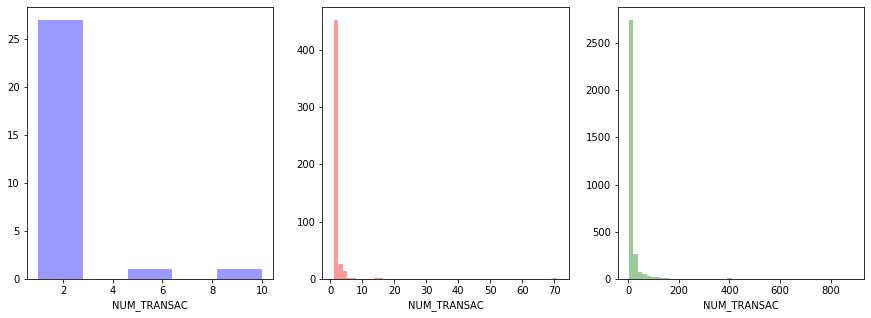

In [10]:
emisores = usuarios.loc[usuarios['USER_TYPE']=='EMISOR']
receptores = usuarios.loc[usuarios['USER_TYPE']=='RECEPTOR']
transacs = usuarios.loc[usuarios['USER_TYPE']=='TRANSACCIONAL']
figura,subFiguras = PyPlot.subplots(1,3,figsize=(15,5))
SeaBorn.distplot(emisores['NUM_TRANSAC'],label='EMISOR',kde=False,ax = subFiguras[0],color='blue')
SeaBorn.distplot(receptores['NUM_TRANSAC'],label='RECEPTOR',kde=False,ax= subFiguras[1],color='red')
SeaBorn.distplot(transacs['NUM_TRANSAC'],label='TRANSACCIONAL',kde=False,ax= subFiguras[2],color='green')
PyPlot.show()

Ahora, podemos ver diferentes aspectos de los usuarios que han entrado a la red. Entre ellos, cómo ha sido el movimiento de los usuarios de solo emisores y receptores a involucrar a los usuarios transaccionales a lo largo del tiempo.

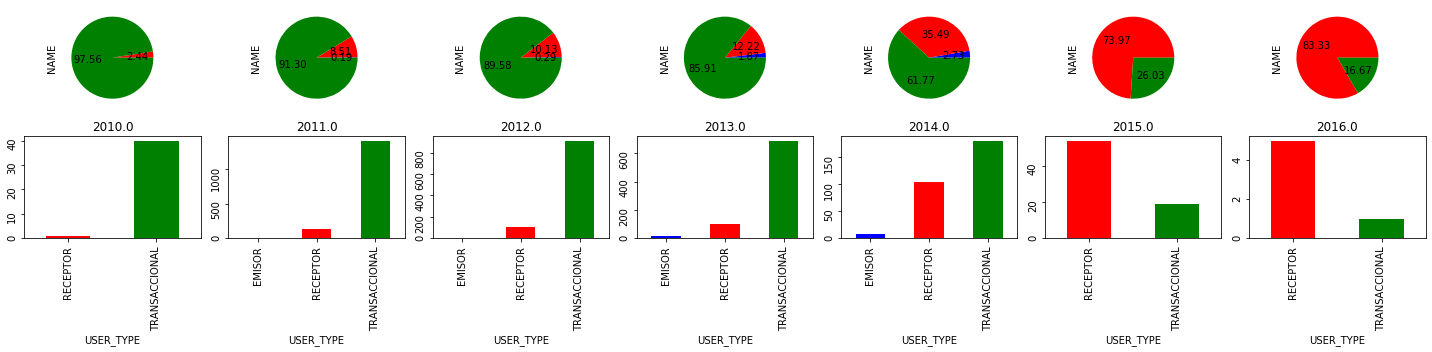

In [18]:
anos = list(usuarios['START_YEAR'].unique())
figura,subFiguras = PyPlot.subplots(2,len(anos),figsize=(20,5),gridspec_kw={'height_ratios':[1,1]})
color_dict={'EMISOR':'blue','RECEPTOR':'red','TRANSACCIONAL':'green'}
for i in range(len(anos)):
    usuarios_ano = usuarios.loc[usuarios['START_YEAR']==anos[i]]
    distribucion_usuarios = usuarios_ano.groupby('USER_TYPE')['NAME'].count()
    colores = [color_dict[tipo] for tipo in distribucion_usuarios.index]
    distribucion_usuarios.plot.pie(colors=colores,
                                   labels=None,
                                   autopct='%.2f',
                                   ax=subFiguras[0,i])
    #subFiguras[0,i].legend(labels=etiquetas,loc=6,bbox_to_anchor=(0,1.15))
    distribucion_usuarios.plot.bar(x=etiquetas,
                                   y='USER_TYPE',
                                   ax=subFiguras[1,i],
                                   color=colores,
                                   title=anos[i],
                                   rot=0,
                                   legend=False)
    subFiguras[1,i].tick_params(labelrotation=90)
PyPlot.tight_layout()
PyPlot.show()

Notemos que la red comienza siendo solamente de emisores a receptores en el año 2010 y regresa a tener solo emisores y receptores en los años 2015 y 2016. Mientras que entre 2011 y 2014 los usuarios transaccionales componen la mayor parte de la red. 

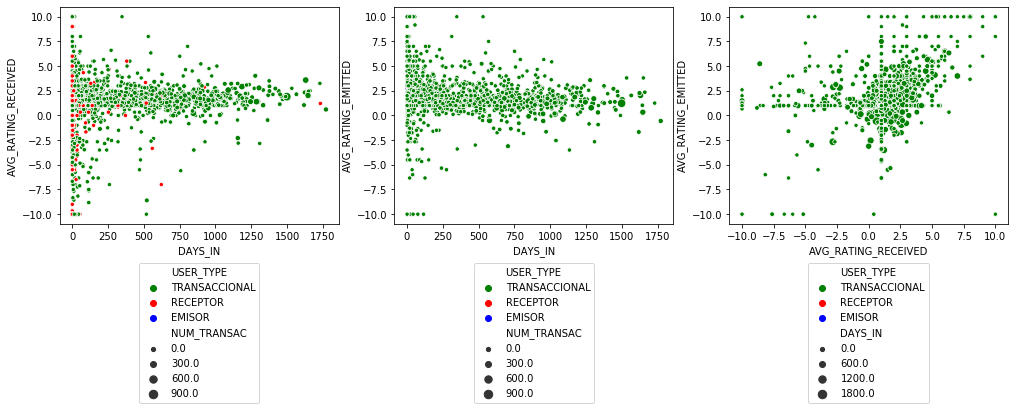

In [19]:
figura,subFiguras = PyPlot.subplots(1,3,figsize=(17,4))
SeaBorn.scatterplot(data=usuarios,x='DAYS_IN',
                    hue='USER_TYPE',
                    y='AVG_RATING_RECEIVED',
                    palette=color_dict,
                    size='NUM_TRANSAC',
                    ax=subFiguras[0])
subFiguras[0].legend(loc='center',bbox_to_anchor=(0.5,-0.5))
SeaBorn.scatterplot(data=usuarios,x='DAYS_IN',
                    hue='USER_TYPE',
                    y='AVG_RATING_EMITTED',
                    size='NUM_TRANSAC',
                    palette=color_dict,
                    ax=subFiguras[1])
subFiguras[1].legend(loc='center',bbox_to_anchor=(0.5,-0.5))
SeaBorn.scatterplot(data=usuarios,
                    x='AVG_RATING_RECEIVED',
                    hue='USER_TYPE',
                    y='AVG_RATING_EMITTED',
                    palette=color_dict,
                    size='DAYS_IN',
                    ax=subFiguras[2])
subFiguras[2].legend(loc='center',bbox_to_anchor=(0.5,-0.5))
PyPlot.show()

Podemos ver que las calificaciones de las transacciones tienen a 2.5 entre más tiempo permanecen los usuarios en la red.
Adicionalmente, la tercera gráfica sugiere que la gran mayoría de usuarios tienden a recibir calificaciones similares a
las dadas. Para estudiar esta distribución de las calificaciones de las transacciones, sería apropiado definir un grafo y esto lo podemos hacer usando la librería NetworkX. 

In [20]:
grafo_transacciones = NetworkX.from_pandas_edgelist(info_red, 
                                          source='SOURCE',
                                          target='TARGET',
                                          edge_attr='RATING',
                                          create_using=NetworkX.DiGraph())

Usaremos este grafo para hacer cálculos específicos sobre los nodos que tienen que ver con sus atributos dentro de la red. Primero, veamos algo de información acerca de este grafo de transacciones.

In [21]:
print('Información: ')
print(NetworkX.classes.function.info(grafo_transacciones))
print()
print('Densidad del grafo')

Información: 
Name: 
Type: DiGraph
Number of nodes: 3783
Number of edges: 24186
Average in degree:   6.3933
Average out degree:   6.3933

Densidad del grafo


Vamos a generar un layout para este grafo que nos permita poner a los vértices en el plano y observar las transacciones. Vamos a dividir los nodos por su año de ingreso a la red en círculos concéntricos.  

In [22]:
shells = []
for ano in anos:
    usuarios_ano = list(usuarios.loc[usuarios['START_YEAR']==ano]['NAME'])
    shells.append(usuarios_ano)
    
pos_vertices = NetworkX.drawing.layout.shell_layout(grafo_transacciones,shells)

In [23]:
pos_dataframe = Pandas.DataFrame(columns=['NAME','pos_x','pos_y'])
pos_aristas = {}
for nombre in pos_vertices.keys():
    nom = float(nombre)
    px = 10*pos_vertices[nombre][0]
    py = 10*pos_vertices[nombre][1]
    pos_aristas[nombre] = [px,py]
    pos_dataframe = pos_dataframe.append({'NAME':nom,'pos_x':px,'pos_y':py},ignore_index=True)

usuarios=Pandas.merge(usuarios,pos_dataframe,on='NAME')
usuarios

,NAME,USER_TYPE,START_YEAR,END_YEAR,DAYS_IN,NUM_EMITTED,NUM_RECEIVED,NUM_TRANSAC,AVG_RATING_EMITTED,AVG_RATING_RECEIVED,pos_x,pos_y
0,113.0,TRANSACCIONAL,2010.0,2014.0,1469.0,38.0,40.0,78.0,2.421053,1.650000,1.287098,0.619834
1,970.0,RECEPTOR,2010.0,2010.0,1.0,0.0,1.0,1.0,NaN,8.000000,1.177397,0.809044
2,402.0,TRANSACCIONAL,2010.0,2014.0,1259.0,15.0,13.0,28.0,1.600000,1.538462,1.040098,0.979292
3,2.0,TRANSACCIONAL,2010.0,2015.0,1630.0,195.0,205.0,400.0,2.035897,3.585366,0.878421,1.126585
4,10.0,TRANSACCIONAL,2010.0,2014.0,1502.0,177.0,164.0,341.0,1.604520,1.756098,0.696154,1.247472
...,...,...,...,...,...,...,...,...,...,...,...,...
3778,3449.0,RECEPTOR,2016.0,2016.0,1.0,0.0,1.0,1.0,NaN,1.000000,-4.999999,-8.660254
3779,2437.0,RECEPTOR,2016.0,2016.0,1.0,0.0,2.0,2.0,NaN,1.000000,4.999999,-8.660254
3780,3450.0,RECEPTOR,2016.0,2016.0,1.0,0.0,1.0,1.0,NaN,1.000000,10.000000,0.000002
3781,7370.0,RECEPTOR,2016.0,2016.0,1.0,0.0,1.0,1.0,NaN,-1.000000,4.999996,8.660256


Con esto podemos tener una visualización de la red, haciendo que los nodos (usuarios) más nuevos queden en los exteriores de la visualización. Veamos por ejemplo dos aspectos:
(1) Los usuarios que tienen más de una transacción
(2) Los usuarios que tienen más de un mes de permanencia en la red.

Vamos a crear una función para graficar el grafo y acortar el código.

In [39]:
def grafico_aros_por_variable(info_nodos,subFigura,var_tamano,var_color,paleta):
    SeaBorn.scatterplot(data=usuarios,x='pos_x',y='pos_y',s=5,color='grey',ax=subFigura)
    SeaBorn.scatterplot(data=info_nodos,x='pos_x',y='pos_y',sizes=(40,400),
                        hue=var_color,size=var_tamano,linewidth=0,
                        palette=paleta,ax=subFigura)
    subFigura.legend(loc='center',bbox_to_anchor=(0.5,-0.25))
    subFigura.axis('off')
    

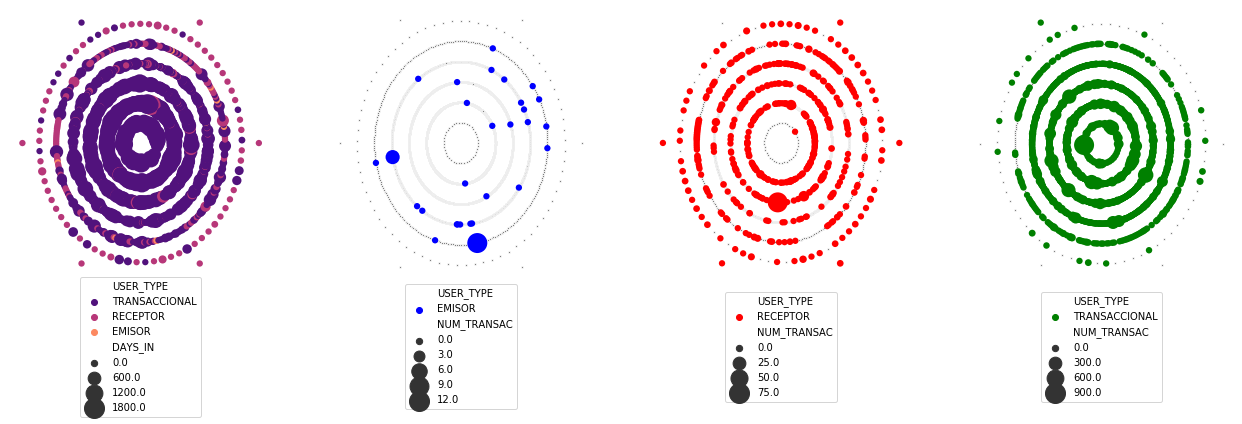

In [42]:
emisores = usuarios.loc[usuarios['USER_TYPE']=='EMISOR']
transacs = usuarios.loc[usuarios['USER_TYPE']=='TRANSACCIONAL']
receptores = usuarios.loc[usuarios['USER_TYPE']=='RECEPTOR']
figura,subFigura = PyPlot.subplots(1,4,figsize=(22,5))
grafico_aros_por_variable(usuarios,subFigura[0],'DAYS_IN','USER_TYPE','magma')
grafico_aros_por_variable(emisores,subFigura[1],'NUM_TRANSAC','USER_TYPE',color_dict)
grafico_aros_por_variable(receptores,subFigura[2],'NUM_TRANSAC','USER_TYPE',color_dict)
grafico_aros_por_variable(transacs,subFigura[3],'NUM_TRANSAC','USER_TYPE',color_dict)
PyPlot.show()

Podemos calcular para cada uno de los nodos varias métricas de nodo con respecto a la red. Esto es, medidas de centralidad para ellos. 

In [26]:
centralidad_grado = NetworkX.algorithms.centrality.degree_centrality(grafo_transacciones)
centralidad_grado_entrada = NetworkX.algorithms.centrality.in_degree_centrality(grafo_transacciones)
centralidad_grado_salida = NetworkX.algorithms.centrality.out_degree_centrality(grafo_transacciones)
centralidad_between = NetworkX.algorithms.centrality.betweenness_centrality(grafo_transacciones)
centralidades = Pandas.DataFrame(columns=['NAME','degree','in_degree','out_degree','between'])
for nodo in centralidad_grado.keys():
    nombre = float(nodo)
    degree = centralidad_grado[nodo]
    in_degree = centralidad_grado_entrada[nodo]
    out_degree = centralidad_grado_salida[nodo]
    between = centralidad_between[nodo]
    centralidades = centralidades.append({'NAME':nombre,
                                          'degree':degree,
                                          'in_degree':in_degree,
                                          'out_degree':out_degree,
                                          'between':between,
                                         },ignore_index=True)
usuarios=Pandas.merge(usuarios,centralidades,on='NAME')
usuarios

,NAME,USER_TYPE,START_YEAR,END_YEAR,DAYS_IN,NUM_EMITTED,NUM_RECEIVED,NUM_TRANSAC,AVG_RATING_EMITTED,AVG_RATING_RECEIVED,pos_x,pos_y,degree,in_degree,out_degree,between
0,113.0,TRANSACCIONAL,2010.0,2014.0,1469.0,38.0,40.0,78.0,2.421053,1.650000,1.287098,0.619834,0.020624,0.010576,0.010048,0.003449
1,970.0,RECEPTOR,2010.0,2010.0,1.0,0.0,1.0,1.0,NaN,8.000000,1.177397,0.809044,0.000264,0.000264,0.000000,0.000000
2,402.0,TRANSACCIONAL,2010.0,2014.0,1259.0,15.0,13.0,28.0,1.600000,1.538462,1.040098,0.979292,0.007403,0.003437,0.003966,0.001042
3,2.0,TRANSACCIONAL,2010.0,2015.0,1630.0,195.0,205.0,400.0,2.035897,3.585366,0.878421,1.126585,0.105764,0.054204,0.051560,0.062452
4,10.0,TRANSACCIONAL,2010.0,2014.0,1502.0,177.0,164.0,341.0,1.604520,1.756098,0.696154,1.247472,0.090164,0.043363,0.046801,0.042906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3778,3449.0,RECEPTOR,2016.0,2016.0,1.0,0.0,1.0,1.0,NaN,1.000000,-4.999999,-8.660254,0.000264,0.000264,0.000000,0.000000
3779,2437.0,RECEPTOR,2016.0,2016.0,1.0,0.0,2.0,2.0,NaN,1.000000,4.999999,-8.660254,0.000529,0.000529,0.000000,0.000000
3780,3450.0,RECEPTOR,2016.0,2016.0,1.0,0.0,1.0,1.0,NaN,1.000000,10.000000,0.000002,0.000264,0.000264,0.000000,0.000000
3781,7370.0,RECEPTOR,2016.0,2016.0,1.0,0.0,1.0,1.0,NaN,-1.000000,4.999996,8.660256,0.000264,0.000264,0.000000,0.000000


Veamos cómo es la distribución de estas centralidades usando histogramas.

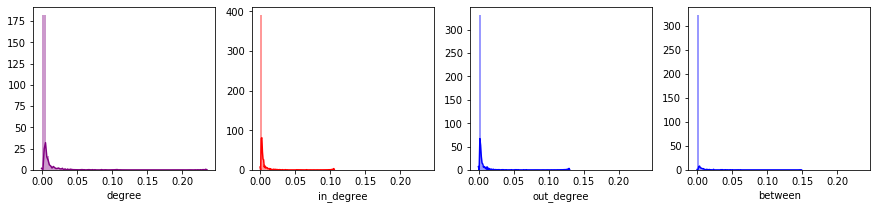

In [28]:
figura,subFigura = PyPlot.subplots(1,4,sharex=True,figsize=(15,3))
SeaBorn.distplot(usuarios['degree'],ax=subFigura[0],color='purple')
SeaBorn.distplot(usuarios['in_degree'],ax=subFigura[1],color='red')
SeaBorn.distplot(usuarios['out_degree'],ax=subFigura[2],color='blue')
SeaBorn.distplot(usuarios['between'],ax=subFigura[3],color='blue')
PyPlot.show()

La gran mayoría de los nodos de esta red tienen centralidades muy cercanas a cero. Veamos la distribución de estos parámetros.

In [76]:
stats_centralidades= usuarios[['degree','in_degree','out_degree','between']].describe()
stats_centralidades

,degree,in_degree,out_degree,between
count,3783.000000,3783.000000,3783.000000,3783.000000
mean,0.003381,0.001690,0.001690,0.000605
std,0.009108,0.004338,0.004837,0.003807
min,0.000264,0.000000,0.000000,0.000000
25%,0.000529,0.000264,0.000264,0.000000
50%,0.001058,0.000529,0.000529,0.000002
75%,0.002644,0.001322,0.001322,0.000140
max,0.234796,0.105235,0.129561,0.149156


Observemos la red dependiendo de cotas para las diferentes centralidades. En este caso vamos a ver solo los nodos de la red que tienen centralidades mayores a 0. Usemos las cotas provistas por los cuartiles para observar los registros que están en el 25% superior de las centralidades.  

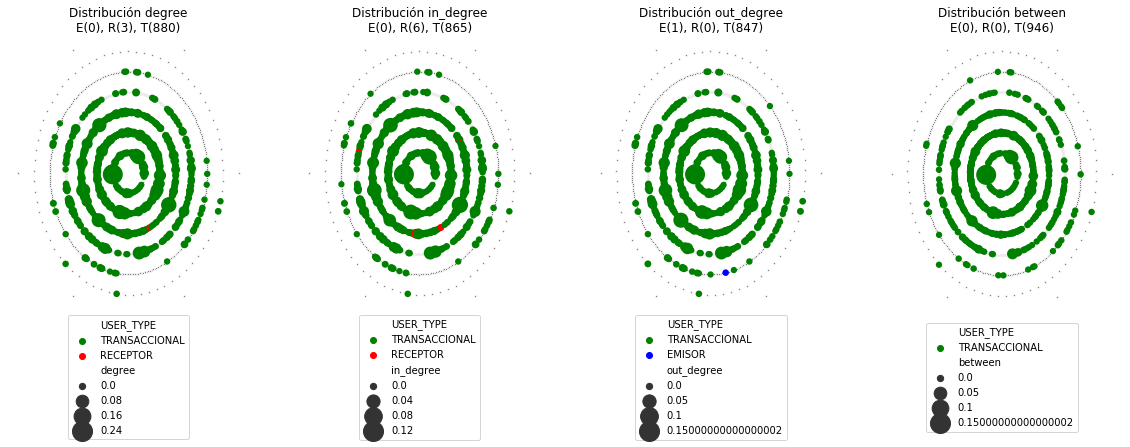

In [81]:
variables = ['degree','in_degree','out_degree','between']
figura,subFigura = PyPlot.subplots(1,len(variables),figsize=(20,5))
for i in range(len(variables)):
    cota = stats_centralidades.loc['75%'][variables[i]]
    sub_datos = usuarios.loc[usuarios[variables[i]] > cota]
    e = len(sub_datos.loc[sub_datos['USER_TYPE']=='EMISOR'])
    r = len(sub_datos.loc[sub_datos['USER_TYPE']=='RECEPTOR'])
    t = len(sub_datos.loc[sub_datos['USER_TYPE']=='TRANSACCIONAL'])
    subFigura[i].set_title('Distribución '+variables[i]+'\n'+'E('+str(e)+'), R('+str(r)+'), T('+str(t)+')')
    grafico_aros_por_variable(sub_datos,subFigura[i],variables[i],'USER_TYPE',color_dict)
PyPlot.show()

# Caracterización de los emisores máximos

De lo que podemos observar en las gráficas. La abrumadora mayoría de nodos que tienen centralidades en el último cuartil son de tipo transaccional. Solo sobreviven de los emisores y receptores pocos nodos receptores (6 según la centralidad de entrada y 1 en la centralidad de salida). Queremos observar primero el comportamiento del nodo emisor con máxima centralidad de salida. Para esto, diseñaremos un par de funciones que nos servirán más adelante para aislar las aristas de los nodos en el cuarto cuartil de las centralidades. 

In [108]:
def filtrar_usuarios_variable(tipo,variable):
    cota = stats_centralidades.loc['75%'][variable]
    sub_usuarios = list(usuarios.loc[(usuarios['USER_TYPE']==tipo) & (usuarios[variable]>cota)]['NAME'])
    return sub_usuarios

def aristas_de_usuarios(nom_usuarios,donde):
    aristas = []
    for arista in grafo_transacciones.edges:
        if donde == 'SOURCE':
            if arista[0] in nom_usuarios:
                aristas.append(arista)
        elif donde=='TARGET':
            if arista[1] in nom_usuarios:
                aristas.append(arista)
        else:
            if arista[0] in nom_usuarios or arista[1] in nom_usuarios:
                aristas.append(arista)
    return aristas

Con esto podemos observar las transacciones efectuadas desde este nodo hacia otros. 

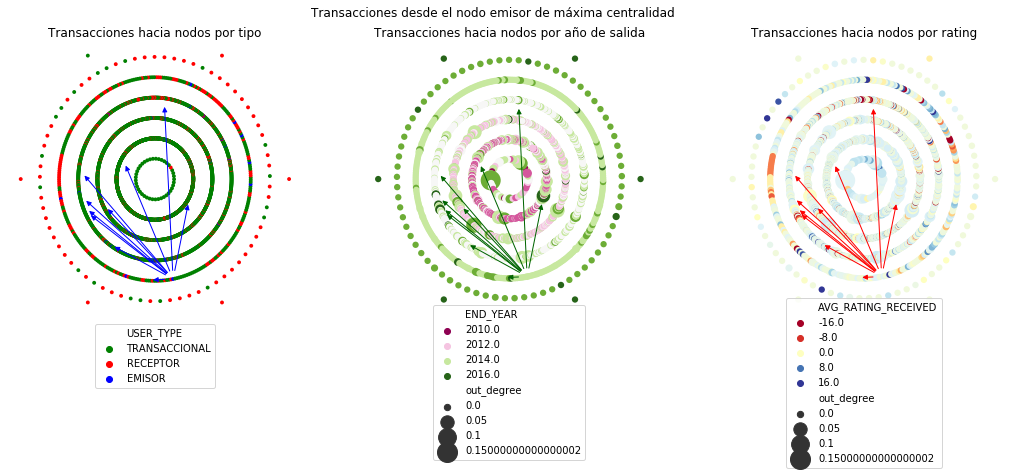

In [170]:
figura,subFigura = PyPlot.subplots(1,3,figsize=(18,5))
figura.suptitle('Transacciones desde el nodo emisor de máxima centralidad')
emisores_maximos = filtrar_usuarios_variable('EMISOR','out_degree')
aristas_emisores = aristas_de_usuarios(emisores_maximos,'SOURCE')

subFigura[0].set_title('Transacciones hacia nodos por tipo')
SeaBorn.scatterplot(data=usuarios,x='pos_x',y='pos_y',s=15,hue='USER_TYPE',linewidth=0,ax=subFigura[0],palette=color_dict)
NetworkX.draw_networkx_edges(grafo_transacciones,pos=pos_aristas,edgelist=aristas_emisores,edge_color='blue',ax=subFigura[0])
subFigura[0].legend(loc='center',bbox_to_anchor=(0.5,-0.15))
subFigura[0].axis('off')

subFigura[1].set_title('Transacciones hacia nodos por año de salida')
grafico_aros_por_variable(usuarios,subFigura[1],'out_degree','END_YEAR','PiYG')
NetworkX.draw_networkx_edges(grafo_transacciones,pos=pos_aristas,edgelist=aristas_emisores,edge_color='darkgreen',ax=subFigura[1])

subFigura[2].set_title('Transacciones hacia nodos por rating')
grafico_aros_por_variable(usuarios,subFigura[2],'out_degree','AVG_RATING_RECEIVED','RdYlBu')
NetworkX.draw_networkx_edges(grafo_transacciones,pos=pos_aristas,edgelist=aristas_emisores,edge_color='red',ax=subFigura[2])
PyPlot.show()                                

Así, podemos observar que este usuario emisor entró a la red en el año 2014 e interactuó con usuarios que entraron en el periodo 2011-2014, siendo la mayor parte de las transacciones con usuarios del 2013. La mayor parte de las transacciones las hizo con usuarios transaccionales. Observemos más en detalle esta interacción. 

In [177]:
emisor_max = emisores_maximos[0]
vecinos = list(grafo_transacciones.neighbors(emisor_max))
info_vecinos = usuarios.loc[usuarios['NAME'].isin(vecinos)]
reporte_vecinos = Pandas.pivot_table(info_vecinos,
                                     index='USER_TYPE',
                                     values=['NAME','AVG_RATING_RECEIVED','DAYS_IN','NUM_TRANSAC','degree'],
                                    aggfunc={'NAME':'count',
                                            'AVG_RATING_RECEIVED':['min','max','mean','std'],
                                            'DAYS_IN':['min','max','mean','std'],
                                            'degree':['mean','std'],
                                            'NUM_TRANSAC':['min','max','mean','std']},
                                     fill_value='-')
reporte_vecinos

AVG_RATING_RECEIVED                               DAYS_IN  \
                              max      mean       min       std     max   
USER_TYPE                                                                 
RECEPTOR                 1.000000  1.000000  1.000000         -    15.0   
TRANSACCIONAL            2.689655  1.646758  0.046512  0.734848  1653.0   

                                           NAME NUM_TRANSAC                    \
                      mean    min     std count         max        mean   min   
USER_TYPE                                                                       
RECEPTOR         15.000000   15.0       -     1         2.0    2.000000   2.0   
TRANSACCIONAL  1109.777778  610.0  366.71     9       320.0  122.555556  43.0   

                          degree             
                   std      mean        std  
USER_TYPE                                    
RECEPTOR             -  0.000529          -  
TRANSACCIONAL  82.3622  0.032405  0.0217774

Este emisor máximo se abstuvo de hacer transacciones con usuarios con solo una entrada a la red (el mínimo es 15 días para el usuario receptor). También, solo interactuó con usuarios con RATINGS positivos (0.04). Interactuó con 10 usuarios en total, 9 de los cuales fueron transaccionales y todos con más de una transacción dentro de la red. 

# Caracterización de los receptores máximos

Habiendo analizado al único emisor máximo (en el cuarto cuartil de la interacción según las medidas de centralidad), podemos analizar ahora a los receptores máximos